# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

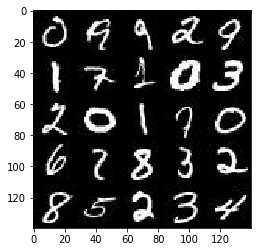

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

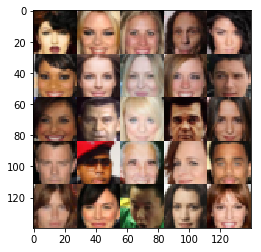

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 7x7x128
        
        # flatten into 1
        flat = tf.reshape(x2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        #7x7x128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    samples = []
    steps = 0

    #call optimizer  
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_images = batch_images * 2

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_z: batch_z, input_real : batch_images, lr: learning_rate})


                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.6574
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.3895
Epoch 1/2... Discriminator Loss: 0.7318... Generator Loss: 2.1858
Epoch 1/2... Discriminator Loss: 0.7529... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 0.8500
Epoch 1/2... Discriminator Loss: 0.9291... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.7812
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.2186
Epoch 1/2... Discriminator Loss: 1.7741... Generator Loss: 0.2428
Epoch 1/2... Discriminator Loss: 1.1048... Generator Loss: 1.2170


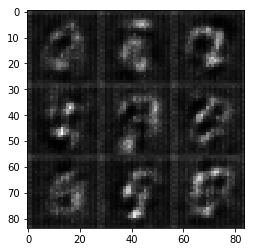

Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 0.9016... Generator Loss: 1.0576
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.3800... Generator Loss: 0.3757
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.3488
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.4010
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.1047
Epoch 1/2... Discriminator Loss: 0.9723... Generator Loss: 1.1416


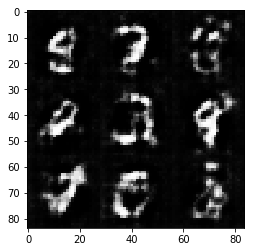

Epoch 1/2... Discriminator Loss: 0.8639... Generator Loss: 1.2599
Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 1.0990
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 1.3907
Epoch 1/2... Discriminator Loss: 1.0388... Generator Loss: 0.5784
Epoch 1/2... Discriminator Loss: 0.7932... Generator Loss: 0.9889
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 0.8780
Epoch 1/2... Discriminator Loss: 0.8263... Generator Loss: 1.4641
Epoch 1/2... Discriminator Loss: 0.8432... Generator Loss: 0.8119


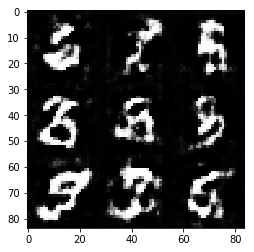

Epoch 1/2... Discriminator Loss: 0.7671... Generator Loss: 1.6215
Epoch 1/2... Discriminator Loss: 0.7601... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 1.5441
Epoch 1/2... Discriminator Loss: 0.8249... Generator Loss: 0.8337
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 0.8906... Generator Loss: 0.7699
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 2.4283
Epoch 1/2... Discriminator Loss: 0.8177... Generator Loss: 1.5265
Epoch 1/2... Discriminator Loss: 0.9352... Generator Loss: 0.7141


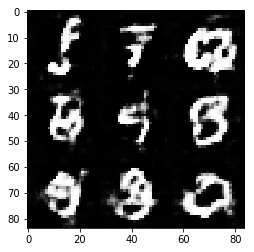

Epoch 1/2... Discriminator Loss: 0.7901... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 0.7649... Generator Loss: 1.1098
Epoch 1/2... Discriminator Loss: 0.9246... Generator Loss: 0.9261
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.9771
Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.5897
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 2.3980
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.3867
Epoch 1/2... Discriminator Loss: 0.8281... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 1.1883... Generator Loss: 0.5263


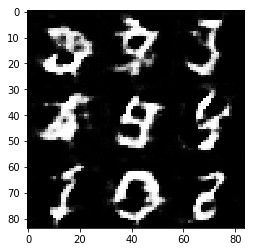

Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.5618
Epoch 1/2... Discriminator Loss: 0.9217... Generator Loss: 0.6656
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.5430
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.3599
Epoch 1/2... Discriminator Loss: 1.7032... Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.4181


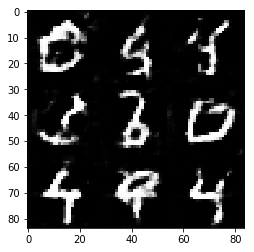

Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.4824
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.2933
Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 0.9193
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.8324
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.1813
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.2918
Epoch 1/2... Discriminator Loss: 0.8527... Generator Loss: 0.9068


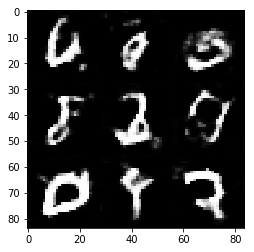

Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 1.0534
Epoch 1/2... Discriminator Loss: 0.8337... Generator Loss: 1.0841
Epoch 1/2... Discriminator Loss: 1.1452... Generator Loss: 1.9217
Epoch 1/2... Discriminator Loss: 0.8423... Generator Loss: 1.0328
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 0.7658
Epoch 1/2... Discriminator Loss: 0.9066... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 2.1005
Epoch 1/2... Discriminator Loss: 1.3617... Generator Loss: 0.4758
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 0.9034
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.7929


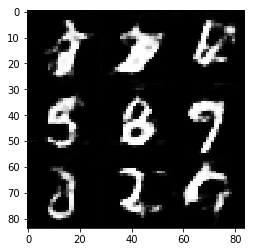

Epoch 1/2... Discriminator Loss: 0.8053... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 1.1139
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 2.2380
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 0.8280
Epoch 1/2... Discriminator Loss: 1.5571... Generator Loss: 0.2911
Epoch 1/2... Discriminator Loss: 0.8139... Generator Loss: 1.0404
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.5524... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 0.6654


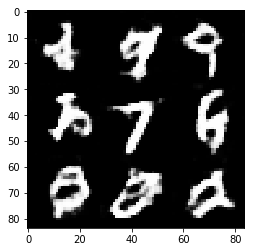

Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 0.7844... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 3.5598... Generator Loss: 4.3027
Epoch 2/2... Discriminator Loss: 0.9642... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 0.9199... Generator Loss: 1.1087
Epoch 2/2... Discriminator Loss: 0.8391... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.0149


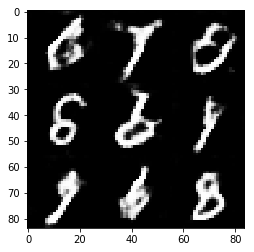

Epoch 2/2... Discriminator Loss: 0.8735... Generator Loss: 0.9026
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.5991
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.7426
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.5115
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 0.9758... Generator Loss: 1.2527
Epoch 2/2... Discriminator Loss: 0.8440... Generator Loss: 1.1893
Epoch 2/2... Discriminator Loss: 0.7805... Generator Loss: 1.0043
Epoch 2/2... Discriminator Loss: 0.8929... Generator Loss: 0.7850


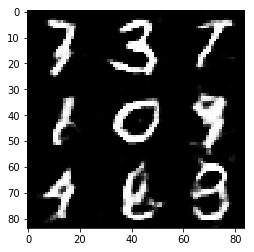

Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 1.4760
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.5740
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.4539
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.0310
Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.5660
Epoch 2/2... Discriminator Loss: 0.9678... Generator Loss: 1.1454
Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 0.7068
Epoch 2/2... Discriminator Loss: 1.0243... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.1843


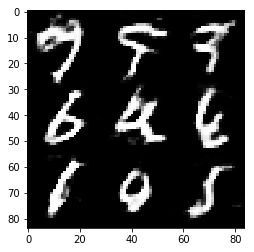

Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 0.9328
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.3522
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 0.5731
Epoch 2/2... Discriminator Loss: 2.0246... Generator Loss: 0.2159
Epoch 2/2... Discriminator Loss: 1.1136... Generator Loss: 1.2970
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 1.1617
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 0.8448... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.1800


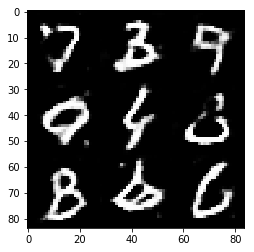

Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.6727
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 0.8974... Generator Loss: 1.2282
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.8073
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 1.3817
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.2975


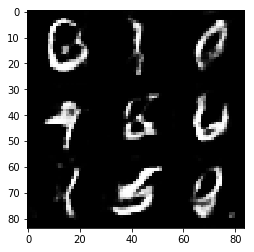

Epoch 2/2... Discriminator Loss: 0.7885... Generator Loss: 1.2812
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.2082
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.8793... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 0.8676... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 0.8520... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.8889... Generator Loss: 0.2190
Epoch 2/2... Discriminator Loss: 0.8442... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 0.6889


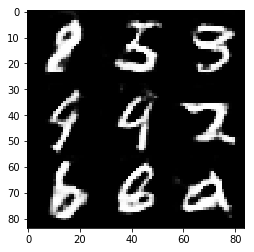

Epoch 2/2... Discriminator Loss: 1.1517... Generator Loss: 0.5698
Epoch 2/2... Discriminator Loss: 0.9006... Generator Loss: 1.4332
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 0.9068... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 0.7483... Generator Loss: 1.5137
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 0.6904
Epoch 2/2... Discriminator Loss: 1.4870... Generator Loss: 0.3997
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.0490


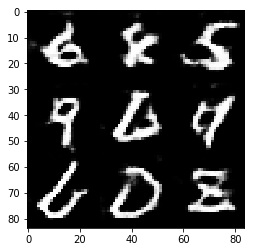

Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.0298
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.4584
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.0748
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.1515
Epoch 2/2... Discriminator Loss: 0.7047... Generator Loss: 1.4367
Epoch 2/2... Discriminator Loss: 2.5443... Generator Loss: 3.3432
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 0.7205
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.5870


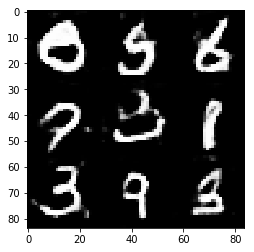

Epoch 2/2... Discriminator Loss: 0.9799... Generator Loss: 0.8490
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 0.8418... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.6730
Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.0197
Epoch 2/2... Discriminator Loss: 2.2642... Generator Loss: 0.1581
Epoch 2/2... Discriminator Loss: 0.9256... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 1.0689... Generator Loss: 0.5937
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 0.8787


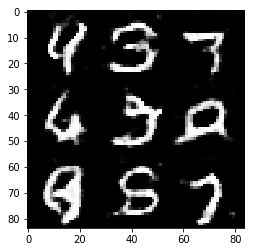

Epoch 2/2... Discriminator Loss: 0.7452... Generator Loss: 1.2011
Epoch 2/2... Discriminator Loss: 0.9487... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.8171... Generator Loss: 0.2483
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.4718
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.2792


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 1.8378
Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 1.9343
Epoch 1/1... Discriminator Loss: 1.7252... Generator Loss: 0.3064
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 2.8742
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 2.5101
Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 2.0683
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 2.2940
Epoch 1/1... Discriminator Loss: 0.8688... Generator Loss: 1.4770


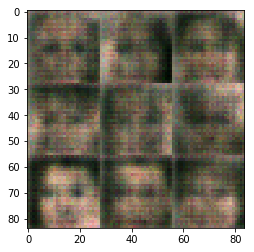

Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.8535
Epoch 1/1... Discriminator Loss: 1.5682... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.9191
Epoch 1/1... Discriminator Loss: 1.3058... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.4484
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0955
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.8437


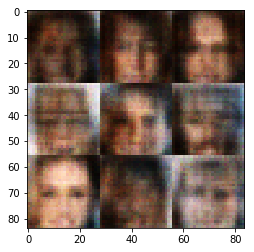

Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.8018
Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.7985... Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.3966
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.5071


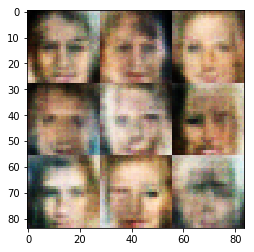

Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.7977... Generator Loss: 2.8316
Epoch 1/1... Discriminator Loss: 0.9396... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 1.0569


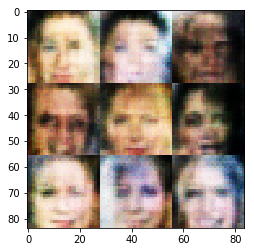

Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 2.0873... Generator Loss: 0.2289
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.7600


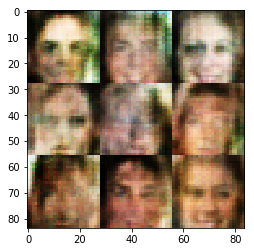

Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.0612


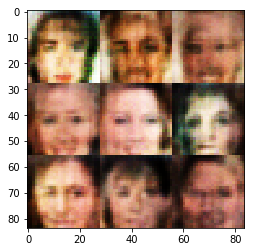

Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8220


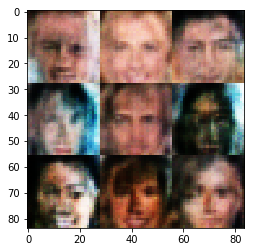

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7015


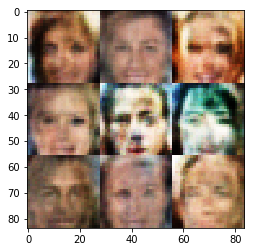

Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6325


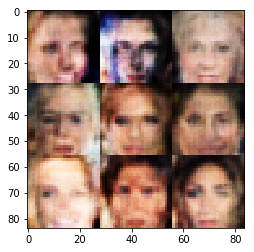

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.9166


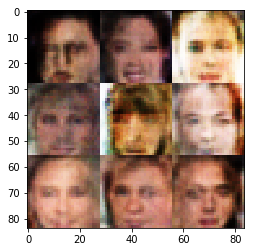

Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 1.0519
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.3376
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5654


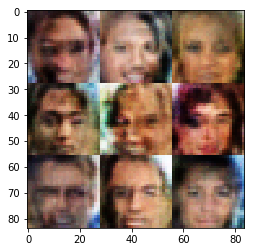

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.4577
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.4564
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.4263
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.5160


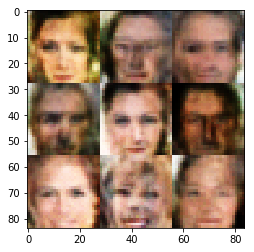

Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.6134
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.5084


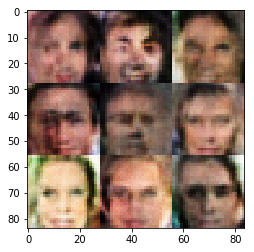

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.